In [45]:
from PIL import Image
import matplotlib.pyplot as plt
import pydicom
import torch
import pandas
import numpy as np
from torch.nn import NLLLoss, Module, Linear, Dropout, LogSoftmax, Sequential, Flatten, Identity, Sigmoid, BCELoss, BCEWithLogitsLoss, MSELoss, Conv2d, L1Loss
from torch.optim import Adam
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Showing Data

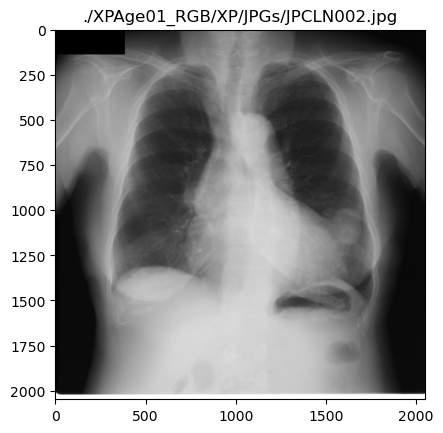

In [11]:
image_path = './XPAge01_RGB/XP/JPGs/JPCLN002.jpg'
img = Image.open(image_path, )
plt.imshow(img, cmap='gray')
plt.title(image_path)
plt.show()

# Age

In [12]:
# def parse(data_indicator):
#     _, split, label, path =  data_indicator.split("\\")
#     path = path.strip()
#     path = path.split(',')[0]
#     return split, label, path


def read_image(path):
    img = Image.open(path)
    return img


# def turn_label(label):
#     if label == 'female':
#         return 0
#     elif label == 'male':
#         return 1


# def do_with_data(path_for_data):
#     with open(path_for_data) as fp:
#         data_indicators = fp.readlines()
    
#     splits, labels, paths = [], [], []
#     for i in data_indicators:
#         split, label, path = parse(i)
#         splits.append(split)
#         labels.append(label)
#         paths.append(path)

#     return splits, labels, paths

# train_splits, train_labels, train_paths = do_with_data('./Gender01_RGB/list_train.txt')
# test_splits, test_labels, test_paths = do_with_data('./Gender01_RGB/list_test.txt')
train = pandas.read_csv('./XPAge01_RGB/XP/trainingdata.csv').values
train_paths = train[:, 0]
train_labels = train[:, 1]

test = pandas.read_csv('./XPAge01_RGB/XP/testdata.csv').values
test_paths = test[:, 0]
test_labels = test[:, 1]

In [13]:
def prepare_data(paths, labels, dataset):
    images = []
    labels_out = []
    # split = splits[0]
    for path, label in zip(paths, labels):
        image = read_image(f'./{dataset}/{path}')
        images.append(image)
        labels_out.append(label)
    index = torch.randperm(len(labels))

    # images = np.stack(images)
    labels_out = torch.tensor([labels_out[i] for i in index])
    images = [images[i] for i in index]

    return images, labels_out


# Modeling

In [26]:
class Classifier(Module):
    def __init__(self, output_size, dropout_rate):
        super(Classifier, self).__init__()

        self.resnet18 = models.resnet18(pretrained=True)
        in_feature = self.resnet18.fc.in_features
        self.resnet18 = Sequential(*list(self.resnet18.children())[:-1])
        
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            Conv2d(1, 3, kernel_size=1),
            lambda t: t.to(self.get_device())
        ])

        # Apply the transformation to the image
        # tensor_image = transform(png_image)
        # self.input_size = input_size
        self.output_size = output_size 
        self.flatten = Flatten(1, -1)
        self.classifier = Linear(in_features=in_feature, out_features=output_size)
        self.dropout_rate = dropout_rate
        self.regularizer = Dropout(self.dropout_rate)
        if self.output_size == 1:
            self.clf_func = Identity()
            # self.clf_func = Sigmoid()
        # elif self.output_size == 2:
            # self.clf_func = Identity()
        else:
            self.clf_func = LogSoftmax(dim=-1)

    def get_device(self):
        return next(self.parameters()).device

    def forward(self, x):
        x = torch.stack([self.transform(i) for i in x])
        # x = self.transform(x)
        hidden = self.resnet18(x)
        hidden = self.flatten(hidden)
        
        hidden = self.classifier(hidden)
        hidden = self.regularizer(hidden)
        return self.clf_func(hidden)
        # self.resnet_features = nn.Sequential(*list(resnet18.children())

In [15]:
def train(model, x, y, optimizer, loss_fn):
    model.train()

    optimizer.zero_grad()

    y_hat = model(x)
    
    loss = loss_fn(y_hat.reshape(-1), y.to(model.get_device()).reshape(-1).float())

    loss.backward()

    optimizer.step()

    return loss.item()

In [63]:
@torch.no_grad()
def eval(model, x, y, batch_size):
    model.eval()
    preds = []
    # print(x[0].shape)
    index = torch.arange(len(x)).to(model.get_device())
    for x_i, y_out in zip(
        torch.split(index, split_size_or_sections=batch_size), 
        torch.split(y, split_size_or_sections=batch_size)
        ):
        # print(x_i)
        x_inp = [x[i] for i in x_i]
        y_hat = model(x_inp)
        preds.extend(y_hat)
        # print(y_hat.round())
        # print(y)
    preds = torch.stack(preds)
    # print(preds)
    # print(y)
    return L1Loss()(preds.reshape(-1), y.to(model.get_device()).reshape(-1))
    # return (y_hat.argmax(-1) == y.to(model.get_device())).float().mean()
    return ((y_hat >= 0.5) == y.to(model.get_device())).float().mean()

# Age Training

In [80]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Classifier(1, 0.1).to(device)
lr = 9e-4
loss_fn = L1Loss()
optimizer = Adam(model.parameters(), lr=lr)
num_epochs = 40
batch_size = 32

165.84721755981445
0 61.540432
--------------
156.84142684936523
1 58.57139
--------------
147.8809051513672
2 54.11
--------------
143.70335388183594
3 47.3118
--------------
140.4266242980957
4 49.385365
--------------
136.16293334960938
5 46.55005
--------------
133.49018096923828
6 43.51866
--------------
129.67325973510742
7 41.88787
--------------
122.09427261352539
8 41.11647
--------------
119.1872787475586
9 40.494247
--------------
112.54629898071289
10 39.46844
--------------
109.3250732421875
11 37.922493
--------------
106.46055221557617
12 36.120804
--------------
99.16982460021973
13 33.848843
--------------
91.95005226135254
14 32.10608
--------------
82.51300811767578
15 31.120022
--------------
79.40436935424805
16 30.4468
--------------
74.39345169067383
17 29.891548
--------------
75.31044006347656
18 28.727068
--------------
57.14027976989746
19 27.762268
--------------
64.13955020904541
20 26.55397
--------------
51.02795600891113
21 24.366991
--------------
49.15

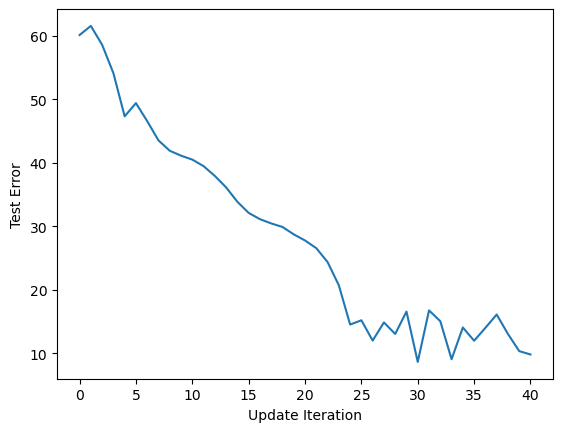

In [81]:
train_x, train_y = prepare_data(train_paths, train_labels, dataset='./XPAge01_RGB/XP/JPGs/')
test_x, test_y = prepare_data(test_paths, test_labels, dataset='./XPAge01_RGB/XP/JPGs/')


index = torch.arange(len(train_x)).to(device)
errors = []


e = eval(model, test_x, test_y, 8).cpu().numpy()
errors.append(e)
for epoch in range(num_epochs):
    epoch_loss = 0
    for x_i, y in zip(
        torch.split(index, split_size_or_sections=batch_size), 
        torch.split(train_y, split_size_or_sections=batch_size)
        ):
        x = [train_x[i] for i in x_i]

        epoch_loss += train(model, x, y, loss_fn=loss_fn, optimizer=optimizer)
    e = eval(model, test_x, test_y, 8).cpu().numpy()
    errors.append(e)
    
    print(epoch_loss)
    print(epoch, e)
    print('--------------')
plt.xlabel('Update Iteration')
plt.ylabel('Test Error')
plt.plot(np.arange(len(errors)), np.array(errors))
plt.show()

In [82]:
min(errors)

array(8.645709, dtype=float32)